In [6]:
# Univariate Time Series Regression using Transformers on Bitcoin Close Price Data
# Short term close bitcoin price prediction using Transformers 

In [12]:
import pandas as pd
import numpy as np

from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from tensorflow.keras import losses
from tensorflow.keras.constraints import MaxNorm as maxnorm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
#from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Audio
#sound_file = 'beep.wav'
from tensorflow.keras.callbacks import *
from sklearn.preprocessing import PowerTransformer

import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import random
import os
from matplotlib import pyplot

from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

In [7]:
# Time 2 Vec Custom Layer for Tensorflow 2

class Time2Vec(Layer):
    
    def __init__(self, dim=None, **kwargs):
        self.dim = dim
        super(Time2Vec, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.Weights = self.add_weight(name='Weights',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.Para = self.add_weight(name='Para',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.weights = self.add_weight(name='weights',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.para = self.add_weight(name='para',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)
        
    def call(Time2Vec, x):
        
        initial = self.weights * x + self.para
        sine_transformation = K.sin(K.dot(x, self.Weights) + self.Para)
        
        return K.concatenate([sine_transformation, initial], -1)


In [3]:
#np.random.seed(7)

In [27]:
# Dataset - FREE HISTORICAL DATA from https://www.cryptodatadownload.com/data/

# Data is organized by exchange and symbol. Please select the exchange grouping below. This data is offered for free under the Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License

dataframe = pd.read_csv("../data/new/gemini_BTCUSD_1hr.csv", sep=',', skiprows=1, 
                        parse_dates=True, squeeze=True, header=0, index_col=1)

#dataframe['Date'] = pd.to_datetime(dataframe['Date'])




In [28]:
dataframe.head(3)

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume
Date,,,,,,,
2021-08-17 00:00:00,1629158400000,BTCUSD,45911.98,46092.77,45855.18,45869.40,8.181504
2021-08-16 23:00:00,1629154800000,BTCUSD,46122.00,46200.48,45729.02,45911.98,64.325364
2021-08-16 22:00:00,1629151200000,BTCUSD,46072.69,46352.96,46006.06,46122.00,45.393337


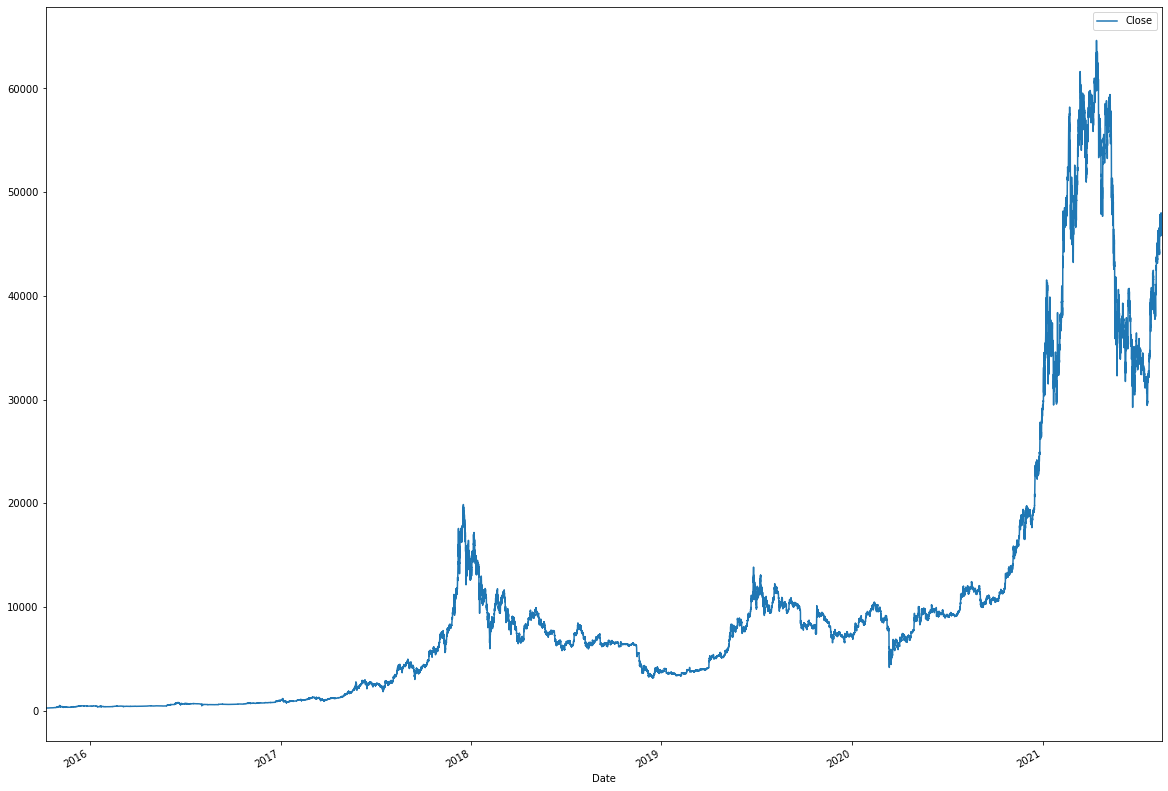

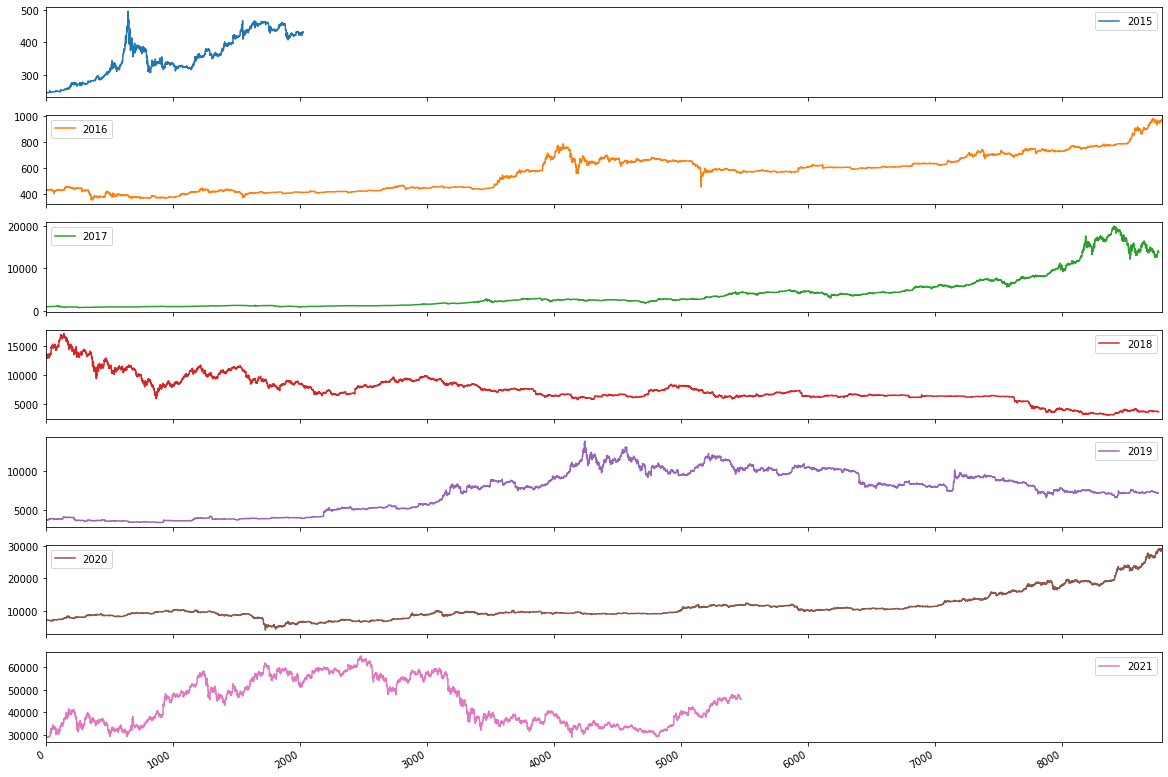

In [93]:
# Data Visualization
import warnings
warnings.filterwarnings('ignore')

# Price Data variation by year
series = dataframe[['Close']]
series.plot()
pyplot.show()

# Price Data variation by hours in a year 24*365=8760
years_ls = []
groups = series.groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
    series_temp = pd.DataFrame()
    series_temp[name.year] = group.values.ravel()
    years_ls.append(name.year)
    years = pd.concat([years,series_temp], ignore_index=True, axis=1)
years.columns = years_ls
years.plot(subplots=True)
pyplot.rcParams["figure.figsize"] = (20,15)
pyplot.show()


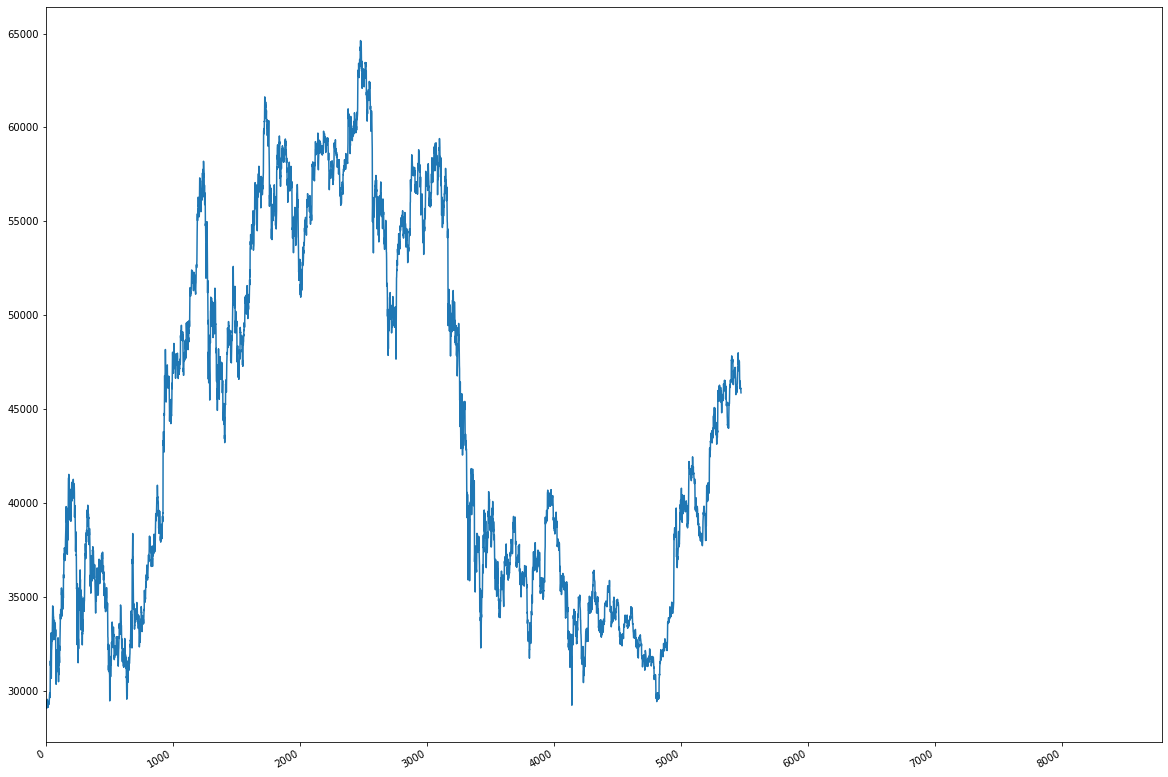

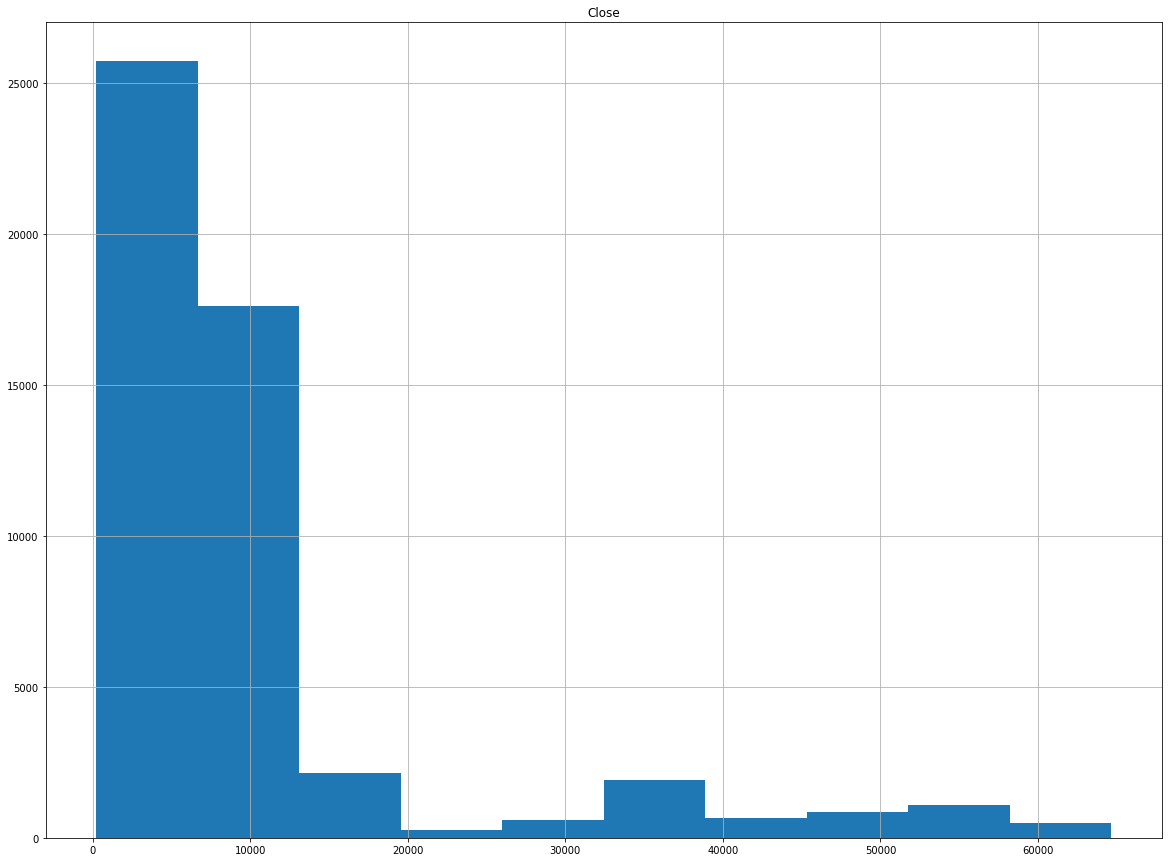

In [97]:
# 2021 Changes
years[2021].plot(subplots=True)
pyplot.rcParams["figure.figsize"] = (20,15)
pyplot.show()


# Histogram of price distribution - as we can see looks highly skewed
series.hist()
pyplot.show()

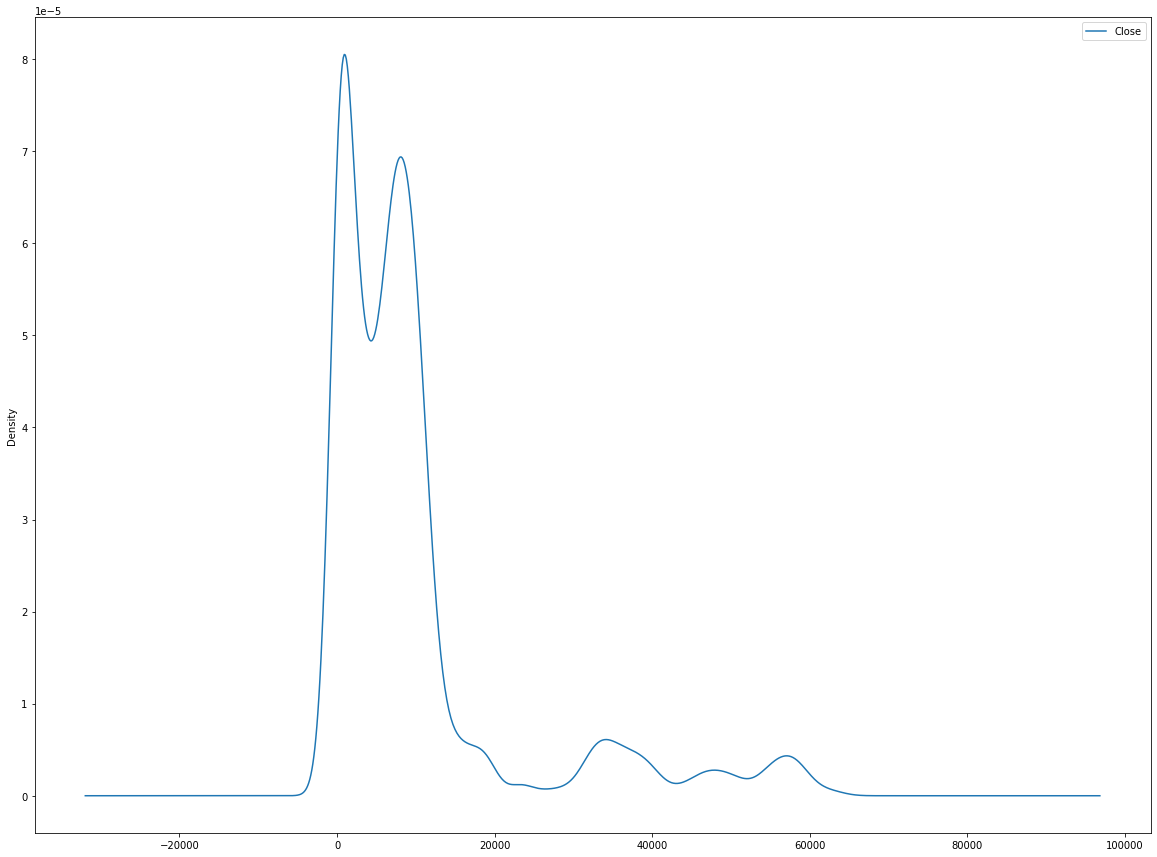

In [98]:
# Density Plot to see the distribution
series.plot(kind='kde')
pyplot.show()

In [5]:
# Preprocessing

length=dataframe.shape[1]-1
df = dataframe

for i in dataframe.columns:
    try:
        dataframe[i] = np.where(dataframe[i] > df[i].quantile(0.75), df[i].quantile(0.50), df[i])
        dataframe[i] = np.where(dataframe[i] < df[i].quantile(0.25), df[i].quantile(0.50), df[i])
    except:
        pass


# from scipy import stats
# import numpy as np
# z = np.abs(stats.zscore(dataframe))

# Q1 = dataframe.quantile(0.25)
# Q3 = dataframe.quantile(0.75)
# IQR = Q3 - Q1


# df_o = dataframe[(z < 3).all(axis=1)]
# df_out = df_o[~((df_o < (Q1 - 1.5 * IQR)) |(df_o > (Q3 + 1.5 * IQR))).any(axis=1)]
# dataframe = df_out

In [7]:
# set(dataframe['priceUSD'])

In [6]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [7]:
dataset = dataframe#[pd.to_datetime(dataframe['Date']) > pd.to_datetime('2017-01-01 00:00:00')]

dataset = dataset[['Close']].values.astype('float32')
# X, y = create_dataset(dataframe[['priceUSD']])
pw_transform = PowerTransformer()
#scaler = MinMaxScaler(feature_range=(0, 1))
dataset = pw_transform.fit_transform(dataset)

# train_size = int(len(dataset) * 0.67)
# test_size = len(dataset) - train_size
# train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
# print(len(train), len(test))

# look_back = 10
# trainX, trainY = create_dataset(train, look_back=look_back)
# testX, testY = create_dataset(test, look_back=look_back)

/root/.pyenv/versions/nlp/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2828: RuntimeWarning: overflow encountered in power
  out[pos] = (np.power(x[pos] + 1, lmbda) - 1) / lmbda
/root/.pyenv/versions/nlp/lib/python3.7/site-packages/numpy/core/_methods.py:183: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
/root/.pyenv/versions/nlp/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/root/.pyenv/versions/nlp/lib/python3.7/site-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


In [71]:
# # split into input (X) and output (Y) variables
# #X = dataframe.iloc[:,0:length]
# #X = X[["hashrate","size90var","difficulty14sma","difficulty30sma","difficulty90sma","difficulty3ema","difficulty7ema"]]
# X = dataframe#[['price7wmaUSD', 'difficulty90var']]
# y = dataframe['priceUSD']
# #X = X.drop(['Date', 'priceUSD'], axis = 1)
# X = X.drop(['priceUSD'], axis = 1)

In [72]:
# X.head(3)
#X = X.drop(['Date', 'priceUSD'], axis = 1)
# #X = dataframe.iloc[:,:-1]

In [73]:
#y=dataframe.iloc[:,-1:]

In [74]:
# shape=X.shape[1]

In [152]:
dataframe[pd.to_datetime(dataframe['Date']) > pd.to_datetime('2019-06-28 00:00:00')]

,Date,priceUSD,price3smaUSD,price7smaUSD,price14smaUSD,price30smaUSD,price3emaUSD,price7emaUSD,price14emaUSD,price30emaUSD,price90emaUSD,price3wmaUSD,price7wmaUSD,price14wmaUSD,price30wmaUSD,price90wmaUSD,transactionvalue90smaUSD,price3momUSD,price90stdUSD
3269,2019/06/29,11867.0,11798.0,11576.0,10537.0,9253.0,11816.0,11458.0,10725.0,9666.0,7678.0,11805.0,11770.0,11133.0,9960.0,8262.0,29913.0,-800.919,3971.0
3270,2019/06/30,11569.0,11713.0,11688.0,10714.0,9360.0,11693.0,11486.0,10837.0,9789.0,7763.0,11691.0,11768.0,11271.0,10109.0,8358.0,30438.0,-256.912,4022.0
3271,2019/07/01,10709.0,11382.0,11666.0,10820.0,9433.0,11201.0,11291.0,10820.0,9848.0,7828.0,11189.0,11523.0,11270.0,10196.0,8433.0,30739.0,-993.205,4046.0
3272,2019/07/02,10323.0,10867.0,11523.0,10903.0,9488.0,10762.0,11049.0,10754.0,9879.0,7883.0,10659.0,11188.0,11204.0,10254.0,8498.0,30988.0,-1545.000,4063.0
3273,2019/07/03,11337.0,10790.0,11333.0,11060.0,9581.0,11049.0,11121.0,10832.0,9973.0,7959.0,10894.0,11141.0,11261.0,10373.0,8584.0,31328.0,-231.729,4111.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4016,2021/07/15,32109.0,32485.0,33117.0,33598.0,34185.0,32495.0,32977.0,33427.0,34509.0,39609.0,32360.0,32884.0,33295.0,33658.0,37467.0,318035.0,-1592.000,18643.0
4017,2021/07/16,31750.0,32116.0,32915.0,33489.0,33929.0,32123.0,32670.0,33204.0,34331.0,39436.0,31993.0,32542.0,33048.0,33501.0,37239.0,316927.0,-1105.000,18320.0
4018,2021/07/17,31556.0,31805.0,32608.0,33293.0,33694.0,31839.0,32391.0,32984.0,34152.0,39263.0,31713.0,32202.0,32790.0,33348.0,37013.0,316752.0,-933.146,18193.0
4019,2021/07/18,31763.0,31690.0,32318.0,33042.0,33519.0,31801.0,32234.0,32821.0,33998.0,39098.0,31692.0,31991.0,32587.0,33224.0,36798.0,315474.0,-346.009,18031.0


In [215]:
# X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, train_size=0.8, shuffle=True, random_state=7)

In [216]:
#estimators=[]

In [217]:
#estimators.append(['mixmax',MinMaxScaler()])

In [218]:
#estimators.append(['robust',RobustScaler()])

In [219]:
#scale=Pipeline(estimators,verbose=True)

In [220]:

# X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, train_size=0.8, shuffle=True, random_state=7)

# X_train=scale.fit_transform(X_train)
# X_test=scale.transform(X_test)

# from sklearn.neighbors import LocalOutlierFactor

# lof = LocalOutlierFactor()
# yhat = lof.fit_predict(X_train)
# mask = yhat != -1
# X_train, y_train = X_train[mask, :], y_train[mask]

# X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
# X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))

# y_train=y_train.values

# y_train=np.reshape(y_train, (y_train.shape[0],1,1))

# y_test=y_test.values

# y_test=np.reshape(y_test,(y_test.shape[0],1,1))

# X_train.shape, y_train.shape

In [221]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [75]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [76]:
# define neural network model
def sequential_model(initializer='normal', activation='relu', neurons=100, NUM_FEATURES=90):
    # create model
    model = Sequential()
    #model = Sequential()
    #model.add(tf.keras.layers.Reshape((NUM_FEATURES,1), input_shape=(NUM_FEATURES,)))
    model.add(LSTM(neurons, return_sequences=True, activation='relu',input_shape=(1, look_back)))
    model.add(T2V(neurons))
    
    #model.add(LSTM(neurons, activation=activation, input_shape=(NUM_FEATURES,1)))
    #model.add(Bidirectional(LSTM(neurons, return_sequences=True, activation='relu')))
    #model.add(Bidirectional(LSTM(350, return_sequences=True, activation='relu')))
    
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(1, activation=activation))
    #model.compile(loss="logcosh", optimizer=adam, metrics=['mae'])
#    model.add(Dense(neurons, input_shape=(NUM_FEATURES,), kernel_initializer=initializer, activation=activation))
#     model.add(Dense(neurons, activation=activation))
#     model.add(Dense(neurons, activation=activation))
    #model.add(tf.keras.layers.Reshape((NUM_FEATURES,1), input_shape=(NUM_FEATURES,)))
    #model.add(T2V(neurons))
    #model.add(LSTM(neurons, activation=activation, input_shape=(NUM_FEATURES,1)))
    #model.add(T2V(neurons))
#     model.add(Dense(1, activation=activation, kernel_initializer=initializer))
#     model.add(T2V(neurons))
#     model.add(Dense(1, activation=activation))
    model.add(Dropout(0.5))
    #model.add(LSTM(neurons, activation=activation))
    # Compile model
    adam=keras.optimizers.Adam(lr=lr_schedule(100), amsgrad=True)
    #sgd=keras.optimizers.SGD(learning_rate=0.08, momentum=0.9, nesterov=False)
    model.compile(loss='mae', optimizer=adam, metrics=['mae'])
    return model

In [77]:
mcp_save = ModelCheckpoint('ANN_reg_seven_new.hdf5', save_best_only=True, monitor='val_loss', mode='auto')
earlyStopping = EarlyStopping(monitor='val_loss', patience=10,verbose=1, mode='auto')

In [78]:
regressor=KerasRegressor(build_fn=sequential_model, batch_size=64, epochs=100,verbose=1, shuffle=True,
                         validation_split=0.1,validation_freq=1,
                        use_multiprocessing=True) #callbacks=[mcp_save,earlyStopping])

In [79]:

regressor.fit(trainX,trainY)


Learning rate:  0.0001


ValueError: Error when checking input: expected lstm_2_input to have shape (1, 10) but got array with shape (10, 1)

In [60]:
y_pred=regressor.predict(testX)
r2_score(testY, y_pred) #training score

15723/15723 [==============================] - 0s 26us/sample


-5.092442444932622

In [182]:
y_pred=regressor.predict(testX)

1325/1325 [==============================] - 0s 47us/sample


In [198]:
testY

array([0.07285933, 0.07285933, 0.07285933, ..., 0.07285933, 0.07285933,
       0.07285933], dtype=float32)

In [229]:
trainPredict = regressor.predict(trainX)
testPredict = regressor.predict(testX)

1316/1316 [==============================] - 0s 30us/sample


In [231]:
trainPredict = scaler.inverse_transform([trainPredict])
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform([testPredict])
testY = scaler.inverse_transform([testY])

In [253]:
import math
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 977.99 RMSE
Test Score: 2747.66 RMSE


In [263]:
max(testPredict[0])

488.38431680298936

In [9]:
df = dataframe.loc[(dataframe['rpt_key'] == 'btc_usd')]


In [144]:
df = dataframe.loc[(dataframe['rpt_key'] == 'btc_usd')]

df = df.reset_index(drop=True)
df['datetime'] = pd.to_datetime(df['datetime_id'])
df = df.loc[df['datetime'] > pd.to_datetime('2017-06-28 00:00:00')]
df = df[['last']]

dataset = df.values
dataset = dataset.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [8]:
train_size = int(len(dataset) * 0.85)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

43643 7702


In [9]:
look_back = 10
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)
# reshape input to be [samples, time steps, features]


In [10]:
# trainPredict = model.predict(trainX)
# testPredict = model.predict(testX)
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor()
yhat = lof.fit_predict(trainX)
mask = yhat != -1
trainX, trainY = trainX[mask, :], trainY[mask]

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

/root/.pyenv/versions/nlp/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


In [168]:
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform([trainY])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([testY])

In [169]:
# import math
# trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY, testPredict))
# print('Test Score: %.2f RMSE' % (testScore))

In [11]:
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(T2V(5))
model.add(LSTM(5, input_shape=(1, look_back)))
#model.add(Dense(10))
model.add(Dense(1))
#model.add(Dropout(0.5))
model.compile(loss='mae', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=32, verbose=2)
model.evaluate(testX, testY, batch_size=64)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 39268 samples
Epoch 1/20
39268/39268 - 16s - loss: 0.0568
Epoch 2/20
39268/39268 - 16s - loss: 0.0076
Epoch 3/20
39268/39268 - 14s - loss: 0.0067
Epoch 4/20
39268/39268 - 10s - loss: 0.0065
Epoch 5/20
39268/39268 - 13s - loss: 0.0064
Epoch 6/20
39268/39268 - 11s - loss: 0.0061
Epoch 7/20
39268/39268 - 15s - loss: 0.0060
Epoch 8/20
39268/39268 - 14s - loss: 0.0061
Epoch 9/20
39268/39268 - 13s - loss: 0.0059
Epoch 10/20
39268/39268 - 12s - loss: 0.0058
Epoch 11/20
39268/39268 - 13s - loss: 0.0057
Epoch 12/20
39268/39268 - 13s - loss: 0.0056
Epoch 13/20
39268/39268 - 15s - loss: 0.0054
Epoch 14/20
39268/39268 - 14s - loss: 0.0054
Epoch 15/20
39268/39268 - 12s - loss: 0.0053
Epoch 16/20
39268/

0.01383488591672726

In [12]:
#look_back = 10
# trainX, trainY = create_dataset(train, look_back=look_back)
# testX, testY = create_dataset(test, look_back=look_back)
# # reshape input to be [samples, time steps, features]
# trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
# testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
import math

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = pw_transform.inverse_transform(trainPredict)
trainY = pw_transform.inverse_transform(trainY.reshape(-1, 1))
testPredict = pw_transform.inverse_transform(testPredict)
testY = pw_transform.inverse_transform(testY.reshape(-1, 1))

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

mae=mean_absolute_error(testY, testPredict) #mape

r2=r2_score(testY, testPredict) #testing score/ r^2
mae, r2

Train Score: 199.94 RMSE
Test Score: 12.45 RMSE


(9.846291, 0.9885790173250855)

In [24]:

# trainY = pw_transform.inverse_transform([trainY])
# import math
# trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
# print('Test Score: %.2f RMSE' % (testScore))

(393.93817, 0.8774393404592309)

In [158]:
trainPredict.shape

(40513, 1)

In [210]:
scaler.inverse_transform(trainX[0])

array([[2545.],
       [2513.],
       [2447.],
       [2431.],
       [2518.],
       [2588.],
       [2566.],
       [2589.],
       [2542.],
       [2513.]], dtype=float32)

In [82]:
#mean_squared_error(model.predict(testX), testY)
testY

array([-0.40524974, -0.5261996 , -0.55549306, -0.51567453, -0.46565238,
       -0.50249815, -0.395962  , -0.3712321 , -0.38329977, -0.37687224,
       -0.30931902, -0.25759357, -0.26427817, -0.26292843, -0.33321333,
       -0.36538306, -0.34129593, -0.39022544, -0.35858595, -0.3783506 ,
       -0.35400635, -0.31116694, -0.29845652, -0.29204506, -0.31744984,
       -0.36125338, -0.33179927, -0.2660618 , -0.21216707, -0.20749106,
       -0.19860502, -0.17321631, -0.1688938 , -0.07612861,  0.0458175 ,
        0.02783652,  0.04093259,  0.06084183,  0.02835072,  0.04933657,
        0.0831614 ,  0.13631697,  0.2066019 ,  0.17844936,  0.01406556,
        0.01527072,  0.02749907,  0.07173648,  0.14827216,  0.14766155,
        0.13043581,  0.1633929 ,  0.17904392,  0.17190936,  0.17145944,
        0.11401349,  0.0876928 ,  0.10038715,  0.08801417,  0.03669043,
        0.04396959,  0.07075628,  0.11685767,  0.13908081,  0.14627963,
        0.15357487,  0.1570618 ,  0.20329173,  0.15404086,  0.17

In [24]:
mean_squared_error(model.predict(trainX), trainY)

0.023421535

In [46]:
pw_transform.inverse_transform(model.predict(trainX)).shape

(981, 1)

In [124]:
model.evaluate(testX, testY, batch_size=8)
# trainPredict = model.predict(trainX)
# testPredict = model.predict(testX)
#pw_transform.inverse_transform(model.predict(trainX))[10], pw_transform.inverse_transform([trainY.reshape(-1, 1)[10]])

6069/6069 [==============================] - 3s 494us/sample - loss: 0.2305


0.23051852215532925

In [134]:
mean_squared_error(model.predict(trainX), trainY.reshape(-1, 1))

0.00014607343

In [131]:
# trainP = scaler.inverse_transform(trainPredict)
# trainYs = scaler.inverse_transform([trainY])
# testP = scaler.inverse_transform(testPredict)
# testYs = scaler.inverse_transform([testY])
# pw_transform.inverse_transform(model.predict(trainX))[5],pw_transform.inverse_transform(trainY.reshape(-1, 1))[5]

In [135]:
model.predict(trainX)

array([[ 1.8761734 ],
       [ 1.8741344 ],
       [ 1.8756566 ],
       ...,
       [-0.66500866],
       [-0.66996396],
       [-0.67400414]], dtype=float32)

In [177]:
trainY[0].shape

(1,)

In [179]:
#look_back = 10
# trainX, trainY = create_dataset(train, look_back=look_back)
# testX, testY = create_dataset(test, look_back=look_back)
# # reshape input to be [samples, time steps, features]
# trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
# testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# import math

# trainPredict = model.predict(trainX)
# testPredict = model.predict(testX)

# trainPredict = pw_transform.inverse_transform(trainPredict)
# trainY = pw_transform.inverse_transform(trainY.reshape(-1, 1))
# testPredict = pw_transform.inverse_transform(testPredict)
# testY = pw_transform.inverse_transform(testY.reshape(-1, 1))

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 224.51 RMSE
Test Score: 678.21 RMSE


In [182]:
mae=mean_absolute_error(testY, testPredict) #mape
mae
r2=r2_score(testY, testPredict) #testing score/ r^2
r2

341.36282

In [183]:
r2=r2_score(testY, testPredict) #testing score/ r^2
r2

0.8988053135655948